In [189]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: generous-jazz-63
MODEL_NAME = "20220602-000656_05_tacotron_8khz_50_epochs__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [190]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [191]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/05_tacotron_8khz_50_epochs.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

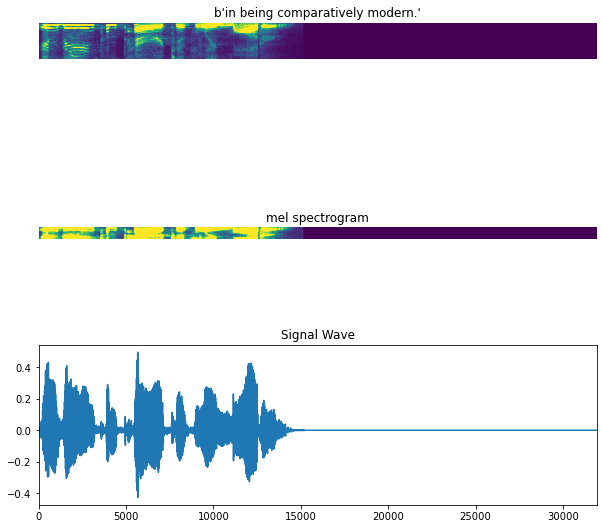

In [193]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [194]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
res = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [195]:
tts = models.TacotronTTS()
tts.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/final')

# model after first epoch
tts_0 = models.TacotronTTS()
tts_0.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_0')

In [196]:
GEN_FRAMES = 600

def summarize_mel_stats(mel_spec, new_mel_spec):
    ref_spec = mel_spec[:GEN_FRAMES,:].flatten()
    pred_spec = new_mel_spec[0].numpy().flatten()
    print(f'L1 {np.abs(pred_spec - ref_spec).mean()}')
    return pd.DataFrame({
        'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(),
        'predicted_mel_spec': new_mel_spec[0].numpy().flatten()
    }).describe()

def mel_spec_viz(mel_spec, extra_title=''):
    ax = plt.subplot(2, 1, 1)
    ax.imshow(np.transpose(mel_spec[0]), vmax=1)
    ax.set_title('predicted mel spectrogram' + extra_title)
    ax.axis("off")

    ax = plt.subplot(2, 1, 2)
    ax.imshow(np.transpose(mel_spec[0]))
    ax.set_title('predicted mel spectrogram normalized' + extra_title)
    ax.axis("off")
    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(encoded[0]))
    ax.set_title('encoded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(embed[0]))
    ax.set_title('embedded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(pre_net[0]))
    ax.set_title('pre_net transcription')
    ax.axis("off")

    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    mask = input != tf.constant(-1, dtype=tf.int64)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)
    conv_bank = tts.tacotron_encoder.cbhg.conv_bank(pre_net)
    pooling = tts.tacotron_encoder.cbhg.pooling(conv_bank)
    conv_proj1 = tts.tacotron_encoder.cbhg.conv_proj1(pooling)
    conv_proj2 = tts.tacotron_encoder.cbhg.conv_proj2(conv_proj1)
    pre_rnn = pre_net + conv_proj2
    rnn = tts.tacotron_encoder.cbhg.rnn_encoder(pre_rnn, mask=mask)

    plt.figure(figsize=(14, 8))
    
    data_sets = [
        encoded, embed, pre_net, conv_bank, pooling,
        conv_proj1, conv_proj2, pre_rnn, rnn
    ]
    captions = [
        'encoded', 'embedded', 'pre_net', 'conv_bank', 'pooling',
        'conv_proj1', 'conv_proj2', 'pre_rnn', 'rnn'
    ]
    
    for ix, (caption, data) in enumerate(zip(captions, data_sets)):
        ax = plt.subplot(1, len(data_sets), ix+1)
        ax.imshow(np.transpose(data[0]))
        ax.set_title(caption)
        ax.axis("off")
        
    plt.show()

In [197]:
# Generate mel_specs

input = tf.expand_dims(enc_transcription[enc_transcription!=-1], 0)
new_mel_spec = tts.decode(input, GEN_FRAMES)
new_mel_spec_0 = tts_0.decode(input, GEN_FRAMES)

In [198]:
summarize_mel_stats(mel_spec, new_mel_spec)

L1 0.7364842891693115


,mel_spec,predicted_mel_spec
count,12000.000000,12000.000000
mean,0.753993,0.017723
std,0.702490,0.053571
min,0.000000,0.000000
25%,0.157966,0.000000
50%,0.609055,0.000000
75%,1.121389,0.000000
max,3.742443,0.421185


In [199]:
summarize_mel_stats(mel_spec, new_mel_spec_0)

L1 0.753991961479187


,mel_spec,predicted_mel_spec
count,12000.000000,1.200000e+04
mean,0.753993,6.826102e-07
std,0.702490,5.316315e-05
min,0.000000,0.000000e+00
25%,0.157966,0.000000e+00
50%,0.609055,0.000000e+00
75%,1.121389,0.000000e+00
max,3.742443,4.525618e-03


In [200]:
mel_spec.shape

(994, 20)

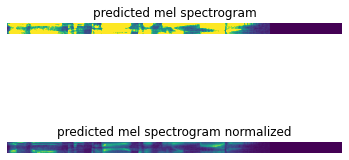

In [201]:
mel_spec_viz([mel_spec[:GEN_FRAMES,:]])

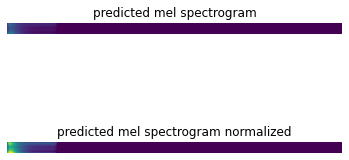

In [202]:
mel_spec_viz(new_mel_spec)

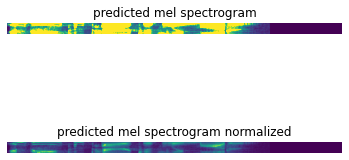

0.7364843


In [208]:
diff = np.abs(mel_spec[:GEN_FRAMES,:]-new_mel_spec[0])
mel_spec_viz([diff])
print(diff.mean())

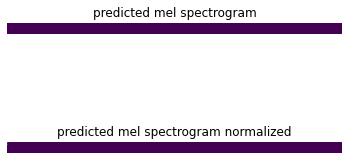

In [209]:
mel_spec_viz(new_mel_spec_0)

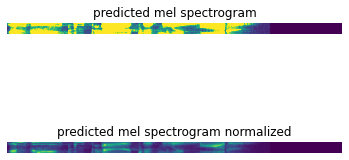

0.75399196


In [210]:
diff = np.abs(mel_spec[:GEN_FRAMES,:]-new_mel_spec_0[0])
mel_spec_viz([diff])
print(diff.mean())

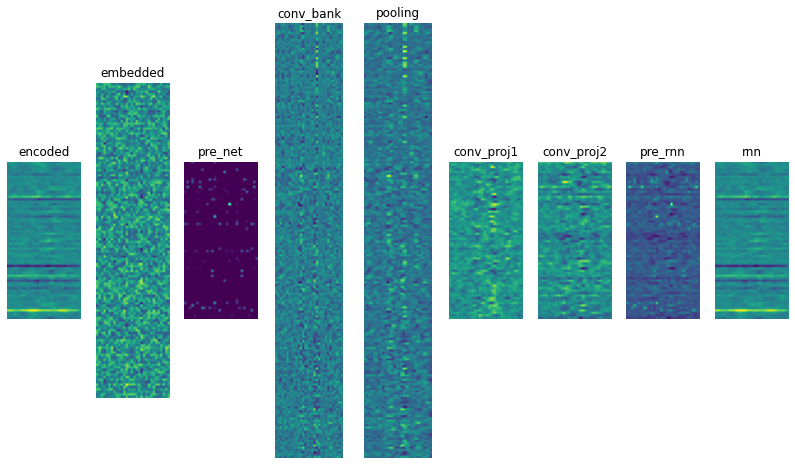

In [211]:
encoder_viz(tts, input)

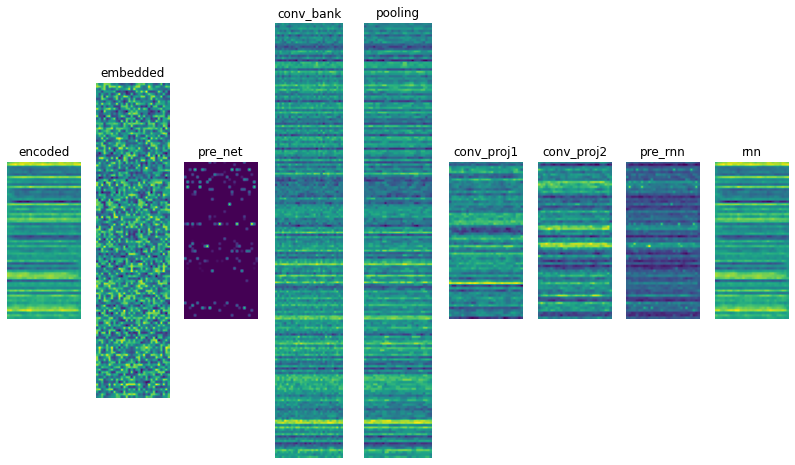

In [212]:
encoder_viz(tts_0, input)

In [213]:
def visualize_attention_states(att_rnn_states):
    data = tf.concat([s[0] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('cell states')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[1] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[2] for s in att_rnn_states], 0)

    plt.figure(figsize=(16, 14))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention state (alignments)')
    ax.axis("off")
    plt.show()

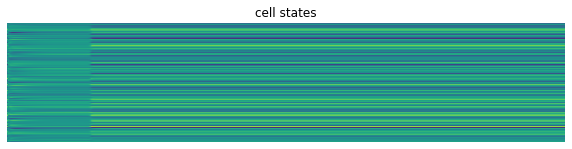

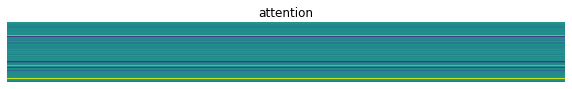

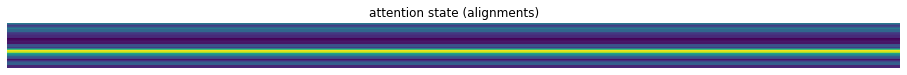

In [214]:
# TRAINED TTS
_, states = tts.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

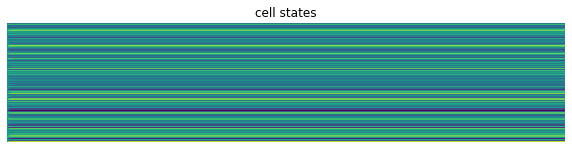

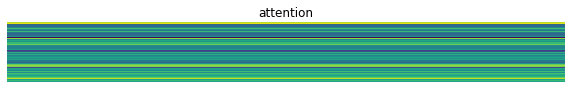

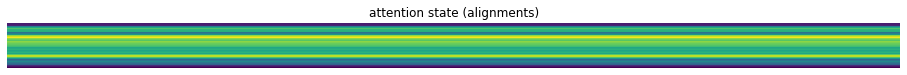

In [215]:
# TRAINED TTS epoch 0
_, states = tts_0.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

# Compare generated mel spectrogram to what is generated in training

In [216]:
tr_mel_spec, tr_enc_transcription = batch[1:3] # Get the relevant columns
tr_inp_mel_spec = tf.pad(tr_mel_spec[:, :-1,:], [(0, 0), (1,0), (0,0)]) # Add the go frame to input spectrogram

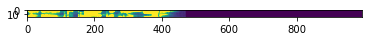

In [217]:
out = tts([tr_enc_transcription[:1], tr_mel_spec[:1]])
plt.imshow(np.transpose(out[0]), vmax=1)

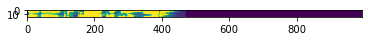

In [218]:
plt.imshow(np.transpose(tr_mel_spec[0]), vmax=1)

In [219]:
np.abs(out[0]-tr_mel_spec[0]).mean()

0.02957283

The model has generated a decent looking mel spectrogram, also the L1 loss looks pretty decent. It's a clear improvement over the epoch 0 model:

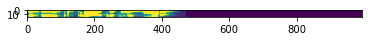

In [220]:
out_0 = tts_0([tr_enc_transcription[0:1], tr_mel_spec[:1]])
plt.imshow(np.transpose(out_0[0]), vmax=1)

In [221]:
np.abs(out_0[0]-tr_mel_spec[0]).mean()

0.08485989

Now, the model is not using the input transcription, as you can see below

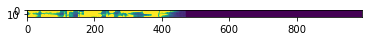

In [222]:
out = tts([tf.constant([[2,3,4,5,6,-1,-1]], dtype=tf.int64), tr_mel_spec[:1]])
plt.imshow(np.transpose(out[0]), vmax=1)

Well, not completely true, we actually see different mel spectrograms being generated when different input transcriptions are used.

Well, at least we know the model has capacity to generate the mel-spectrogram ;).